In [1]:
import re
import string

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(
        preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english        # remove stopwords
            and word not in string.punctuation): # remove punctuation
            stem_word = stemmer.stem(word)       # stemming word
            tweets_clean.append(stem_word)
    return tweets_clean

In [3]:
def test_lookup(func):
    freqs = {('sad', 0): 4,
             ('happy', 1): 12,
             ('oppressed', 0): 7}
    word = 'happy'
    label = 1
    if func(freqs, word, label) == 12:
        return 'SUCCESS!!'
    return 'Failed Sanity Check!'

In [4]:
def lookup(freqs, word, label):
    '''
    Input:
        freqs: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Output:
        n: the number of times the word with its corresponding label 
          appears.
    '''
    n = 0  # freqs.get((word, label), 0)
    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]
    return n

 ## Calculate the likelihoods for each tweet

For each tweet, we have calculated the likelihood of the tweet to be positive and the likelihood to be negative. We have calculated in different columns the numerator and denominator of the likelihood ratio introduced previously.  

$$log \frac{P(tweet|pos)}{P(tweet|neg)} = log(P(tweet|pos)) - log(P(tweet|neg)) $$
$$positive = log(P(tweet|pos)) = \sum_{i=0}^{n}{log P(W_i|pos)}$$
$$negative = log(P(tweet|neg)) = \sum_{i=0}^{n}{log P(W_i|neg)}$$

We did not include the code because this is part of this week's assignment.  The __'bayes_features.csv'__ file contains the final result of this process. 

The cell below loads the table in a dataframe. Dataframes are data structures that simplify the manipulation of data, allowing filtering, slicing, joining, and summarization.

In [5]:
data = pd.read_csv('bayes_features.csv')
data.head(5)

,positive,negative,sentiment
0,-45.763393,-63.351354,1.0
1,-105.491568,-114.204862,1.0
2,-57.028078,-67.216467,1.0
3,-10.055885,-18.589057,1.0
4,-125.749270,-138.334845,1.0


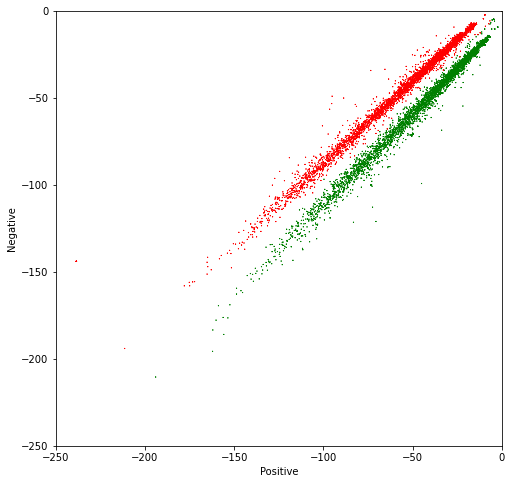

In [6]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['red', 'green']
ax.scatter(data.positive, 
           data.negative, 
           c=[colors[int(k)] for k in data.sentiment], 
           s=0.1, 
           marker='*')
plt.xlim(-250, 0)
plt.ylim(-250, 0)
plt.xlabel('Positive')
plt.ylabel('Negative');

In [8]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's 
        radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

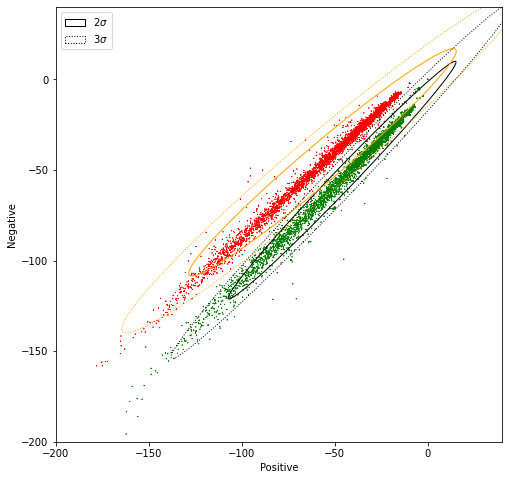

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(data.positive, 
           data.negative, 
           c=[colors[int(k)] for k in data.sentiment], 
           s=0.1, 
           marker='*')
plt.xlim(-200, 40)  
plt.ylim(-200, 40)
plt.xlabel('Positive')
plt.ylabel('Negative')

data_pos = data[data.sentiment == 1]
data_neg = data[data.sentiment == 0]
confidence_ellipse(data_pos.positive, 
                   data_pos.negative, 
                   ax, 
                   n_std=2, 
                   edgecolor='black', 
                   label=r'$2\sigma$' )
confidence_ellipse(data_neg.positive, 
                   data_neg.negative, 
                   ax, 
                   n_std=2, 
                   edgecolor='orange')
confidence_ellipse(data_pos.positive, 
                   data_pos.negative, 
                   ax, 
                   n_std=3, 
                   edgecolor='black', 
                   linestyle=':', 
                   label=r'$3\sigma$')
confidence_ellipse(data_neg.positive, 
                   data_neg.negative, 
                   ax, 
                   n_std=3, 
                   edgecolor='orange', 
                   linestyle=':')
ax.legend();

In [10]:
data2 = data.copy()
# The following 2 lines only modify the entries in the data frame where 
# sentiment == 1
data2.negative[data.sentiment == 1] =  data2.negative * 1.5 + 50
data2.positive[data.sentiment == 1] =  data2.positive / 1.5 - 50

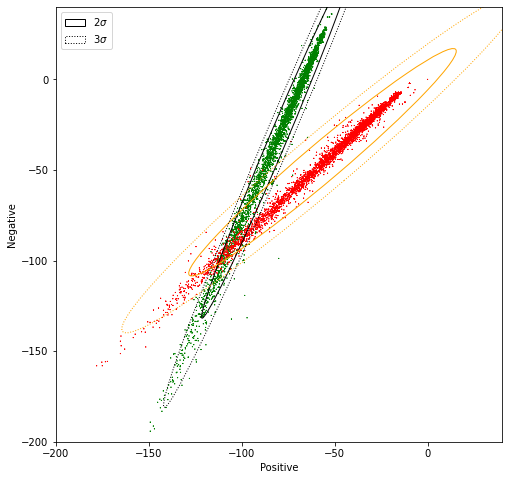

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
#data.negative[data.sentiment == 1] =  data.negative * 2
ax.scatter(data2.positive, 
           data2.negative, 
           c=[colors[int(k)] for k in data2.sentiment], 
           s=0.1, 
           marker='*')
plt.xlim(-200, 40)  
plt.ylim(-200, 40)
plt.xlabel('Positive')
plt.ylabel('Negative')
data_pos = data2[data2.sentiment == 1]
data_neg = data[data2.sentiment == 0]
confidence_ellipse(data_pos.positive, 
                   data_pos.negative, 
                   ax, 
                   n_std=2, 
                   edgecolor='black', 
                   label=r'$2\sigma$' )
confidence_ellipse(data_neg.positive, 
                   data_neg.negative, 
                   ax, 
                   n_std=2, 
                   edgecolor='orange')
confidence_ellipse(data_pos.positive, 
                   data_pos.negative, 
                   ax, 
                   n_std=3, 
                   edgecolor='black', 
                   linestyle=':', 
                   label=r'$3\sigma$')
confidence_ellipse(data_neg.positive, 
                   data_neg.negative, 
                   ax, 
                   n_std=3, 
                   edgecolor='orange', 
                   linestyle=':')
ax.legend();